# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
# scipy should be of version 1.2.0 for imread package

import datetime
import os

from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('../train.csv').readlines())
val_doc = np.random.permutation(open('../val.csv').readlines())
batch_size = 15 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30,2)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            y=120
            z=120
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            cnt_img=0
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    norm_image = image/255.0 # normalizing the image 
                    image_resized=resize(norm_image, (120,120), mode='reflect')
                    
                    
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        cnt_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            for folder in range(rem):
                imgs = os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    norm_image = image/255.0 # normalizing the image 
                    image_resized=resize(norm_image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '../train'
val_path = '../val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#### Model 1 : Conv2D layers + GRU Layer+ Adam optimiser + No dropout

In [87]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15


# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [88]:
from keras.optimizers import Adam
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_63 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_64 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_65 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_66 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_67 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_68 (TimeDis (None, 15, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 15, 15, 15, 64)    18496     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [89]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [90]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [91]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [92]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size =Epoch 1/10
 15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 86s 2s/step - loss: 1.3120 - categorical_accuracy: 0.4474 - val_loss: 1.7706 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-11-0819_31_38.766386/model-00001-1.31201-0.44741-1.77059-0.40000.h5
Epoch 2/10
45/45 [==============================] - 52s 1s/step - loss: 0.8223 - categorical_accuracy: 0.6933 - val_loss: 2.2743 - val_categorical_accuracy: 0.4952

Epoch 00002: saving model to model_init_2020-11-0819_31_38.766386/model-00002-0.82229-0.69333-2.27431-0.49524.h5
Epoch 3/10
45/45 [==============================] - 57s 1s/step - loss: 0.6421 - categorical_accuracy: 0.7570 - val_loss: 1.6559 - val_categorical_accuracy: 0.5524

Epoch 00003: saving model to model_init_2020-11-0819_31_38.766386/model-00003-0.64214-0.75704-1.65592-0.55238.h5
Epoch 4/10
45/45 [==============================] - 63s 1s/step - loss: 0.4504 - categorical_accuracy: 0.8696 - val_loss: 2.3561 - val_categorical_accuracy: 0.5619

Epoch 00004:

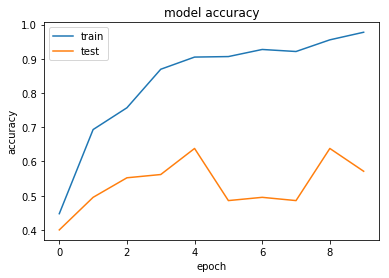

In [94]:
# summarize for model accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Observation
- The accuracy on the training dataset in very high while the accuracy on the validation dataset is too less.
- This is an indication of overfitting on the training dataset.


#### Model 2 : Conv2D layers + GRU Layer +  Adam optimiser +  dropout

In [95]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [96]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_76 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_77 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_78 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_79 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_80 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_81 (TimeDis (None, 15, 15, 15, 32)    0         
__________

In [97]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [98]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [99]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [100]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 76s 2s/step - loss: 1.5170 - categorical_accuracy: 0.3333 - val_loss: 1.7282 - val_categorical_accuracy: 0.4381

Epoch 00001: saving model to model_init_2020-11-0819_31_38.766386/model-00001-1.51701-0.33333-1.72821-0.43810.h5
Epoch 2/10
45/45 [==============================] - 42s 929ms/step - loss: 1.2075 - categorical_accuracy: 0.4933 - val_loss: 1.8931 - val_categorical_accuracy: 0.4190

Epoch 00002: saving model to model_init_2020-11-0819_31_38.766386/model-00002-1.20752-0.49333-1.89311-0.41905.h5
Epoch 3/10
45/45 [==============================] - 66s 1s/step - loss: 0.9993 - categorical_accuracy: 0.6133 - val_loss: 1.8363 - val_categorical_accuracy: 0.4857

Epoch 00003: saving model to model_init_2020-11-0819_31_38.766386/model-00003-0.99933-0.61333-1.83626-0.48571.h5
Epoch 4/10
45/45 [==============================] - 57s 1s/step - loss: 0.8103 - categorical_accuracy: 0.6889 - val_loss: 1.3935 - val_categorical_accuracy: 0.6381

Epoch 000

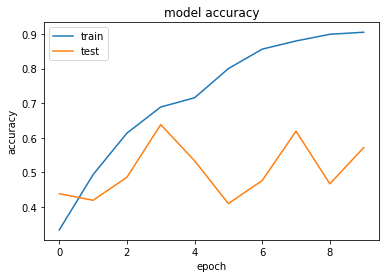

In [101]:
# summarize for model accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 3 : Conv2D layers + GRU Layer+  Adam optimiser + dropout + L2 regularization

In [102]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [103]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_89 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_90 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_91 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_92 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_93 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_94 (TimeDis (None, 15, 15, 15, 32)    0         
__________

In [104]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [105]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [106]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [107]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 77s 2s/step - loss: 2.9672 - categorical_accuracy: 0.3526 - val_loss: 3.2595 - val_categorical_accuracy: 0.4190

Epoch 00001: saving model to model_init_2020-11-0819_31_38.766386/model-00001-2.96722-0.35259-3.25951-0.41905.h5
Epoch 2/10
45/45 [==============================] - 52s 1s/step - loss: 2.4025 - categorical_accuracy: 0.5067 - val_loss: 3.1574 - val_categorical_accuracy: 0.4381

Epoch 00002: saving model to model_init_2020-11-0819_31_38.766386/model-00002-2.40249-0.50667-3.15741-0.43810.h5
Epoch 3/10
45/45 [==============================] - 60s 1s/step - loss: 1.9628 - categorical_accuracy: 0.6326 - val_loss: 3.2627 - val_categorical_accuracy: 0.4667

Epoch 00003: saving model to model_init_2020-11-0819_31_38.766386/model-00003-1.96276-0.63259-3.26270-0.46667.h5
Epoch 4/10
45/45 [==============================] - 58s 1s/step - loss: 1.6666 - categorical_accuracy: 0.6963 - val_loss: 2.7627 - val_categorical_accuracy: 0.4667

Epoch 00004:

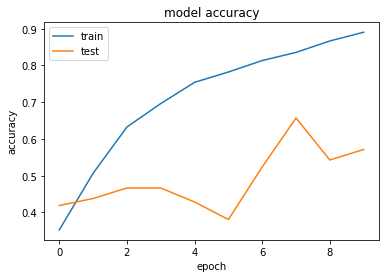

In [108]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 4 : Conv2D layers + GRU Layer+ SDG  optimiser + dropout + L2 regularization

In [109]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

 # using Softmax as last layer
model.add(Dense(num_classes, activation='softmax'))

In [110]:
optimiser = "sgd" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_102 (TimeDi (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_103 (TimeDi (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_104 (TimeDi (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_105 (TimeDi (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_106 (TimeDi (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_107 (TimeDi (None, 15, 15, 15, 32)    0         
__________

In [111]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [112]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [113]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [114]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 80s 2s/step - loss: 3.2546 - categorical_accuracy: 0.2533 - val_loss: 3.5191 - val_categorical_accuracy: 0.2571

Epoch 00001: saving model to model_init_2020-11-0819_31_38.766386/model-00001-3.25460-0.25333-3.51906-0.25714.h5
Epoch 2/10
45/45 [==============================] - 50s 1s/step - loss: 3.0493 - categorical_accuracy: 0.3911 - val_loss: 3.3852 - val_categorical_accuracy: 0.2667

Epoch 00002: saving model to model_init_2020-11-0819_31_38.766386/model-00002-3.04926-0.39111-3.38520-0.26667.h5
Epoch 3/10
45/45 [==============================] - 58s 1s/step - loss: 2.7906 - categorical_accuracy: 0.5007 - val_loss: 4.0924 - val_categorical_accuracy: 0.2190

Epoch 00003: saving model to model_init_2020-11-0819_31_38.766386/model-00003-2.79060-0.50074-4.09244-0.21905.h5
Epoch 4/10
45/45 [==============================] - 60s 1s/step - loss: 2.5932 - categorical_accuracy: 0.5748 - val_loss: 3.6762 - val_categorical_accuracy: 0.3429

Epoch 00004:

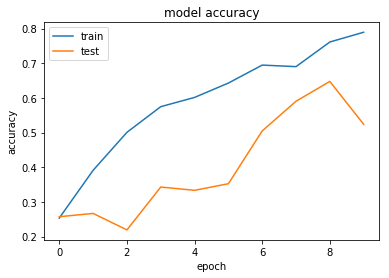

In [115]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 5 : Conv3D layers + Dropout + Batch Normalization + L2 Regularization

In [7]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()


model.add(Conv3D(num_featuremaps[0], (3, 3, 3), padding = 'same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(Dropout(0.25))
          
model.add(Conv3D(num_featuremaps[1], (2, 2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))

model.add(Conv3D(num_featuremaps[2], (2, 2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(Dropout(0.25))
          
model.add(Flatten())
          
model.add(Dense(num_denselayers[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(num_denselayers[1], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          

 # using Softmax as last layer
model.add(Dense(num_classes, activation='softmax'))

In [8]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 7, 60, 60, 32)     0         
__________

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [12]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 167s 4s/step - loss: 4.1694 - categorical_accuracy: 0.2430 - val_loss: 3.6613 - val_categorical_accuracy: 0.3810

Epoch 00001: saving model to model_init_2020-11-0912_04_23.307610/model-00001-4.16941-0.24296-3.66128-0.38095.h5
Epoch 2/10
45/45 [==============================] - 78s 2s/step - loss: 3.0612 - categorical_accuracy: 0.3156 - val_loss: 3.4030 - val_categorical_accuracy: 0.4190

Epoch 00002: saving model to model_init_2020-11-0912_04_23.307610/model-00002-3.06124-0.31556-3.40296-0.41905.h5
Epoch 3/10
45/45 [==============================] - 78s 2s/step - loss: 2.7008 - categorical_accuracy: 0.3467 - val_loss: 2.9066 - val_categorical_accuracy: 0.4476

Epoch 00003: saving model to model_init_2020-11-0912_04_23.307610/model-00003-2.70079-0.34667-2.90655-0.44762.h5
Epoch 4/10
45/45 [==============================] - 98s 2s/step - loss: 2.4020 - categorical_accuracy: 0.4489 - val_loss: 2.7684 - val_categorical_accuracy: 0.5048

Epoch 00004

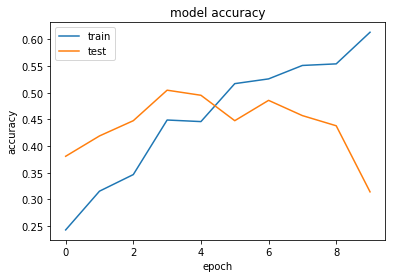

In [13]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 6 : Transfer Learning + Resnet50 +  dropout +  GRU Layer

In [8]:
from keras.applications.resnet50 import ResNet50

In [9]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model

resnet_model = ResNet50(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(resnet_model,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))


model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [10]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 8192)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                1585344   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
__________

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [14]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15Epoch 1/10



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 117s 3s/step - loss: 1.5636 - categorical_accuracy: 0.3200 - val_loss: 1.7821 - val_categorical_accuracy: 0.3429

Epoch 00001: saving model to model_init_2020-11-0912_44_25.363423/model-00001-1.56365-0.32000-1.78212-0.34286.h5
Epoch 2/10
45/45 [==============================] - 85s 2s/step - loss: 1.2673 - categorical_accuracy: 0.4785 - val_loss: 2.3303 - val_categorical_accuracy: 0.3333

Epoch 00002: saving model to model_init_2020-11-0912_44_25.363423/model-00002-1.26732-0.47852-2.33032-0.33333.h5
Epoch 3/10
45/45 [==============================] - 85s 2s/step - loss: 1.1970 - categorical_accuracy: 0.5274 - val_loss: 1.9942 - val_categorical_accuracy: 0.2571

Epoch 00003: saving model to model_init_2020-11-0912_44_25.363423/model-00003-1.19697-0.52741-1.99421-0.25714.h5
Epoch 4/10
45/45 [==============================] - 85s 2s/step - loss: 1.2174 - categorical_accuracy: 0.5230 - val_loss: 2.3283 - val_categorical_accuracy: 0.2667

Epoch 00004

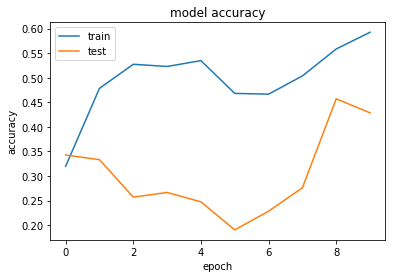

In [15]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 7 : Transfer Learning + VGGNET + dropout + GRU Layer

In [16]:
from keras.applications.vgg16 import VGG16

In [17]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
vgg_model = VGG16(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(vgg_model,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))


model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1], activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

In [18]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 512)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                110784    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size =Source path =  ../train ; batch size = 15
Epoch 1/10
 15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 107s 2s/step - loss: 1.6400 - categorical_accuracy: 0.2681 - val_loss: 2.0239 - val_categorical_accuracy: 0.2095

Epoch 00001: saving model to model_init_2020-11-0912_44_25.363423/model-00001-1.63997-0.26815-2.02394-0.20952.h5
Epoch 2/10
45/45 [==============================] - 84s 2s/step - loss: 1.4651 - categorical_accuracy: 0.3481 - val_loss: 1.8896 - val_categorical_accuracy: 0.2476

Epoch 00002: saving model to model_init_2020-11-0912_44_25.363423/model-00002-1.46506-0.34815-1.88962-0.24762.h5
Epoch 3/10
45/45 [==============================] - 84s 2s/step - loss: 1.4681 - categorical_accuracy: 0.3630 - val_loss: 3.1518 - val_categorical_accuracy: 0.1905

Epoch 00003: saving model to model_init_2020-11-0912_44_25.363423/model-00003-1.46808-0.36296-3.15180-0.19048.h5
Epoch 4/10
45/45 [==============================] - 84s 2s/step - loss: 1.3777 - categorical_accuracy: 0.4030 - val_loss: 1.8834 - val_categorical_accuracy: 0.2857

Epoch 00004

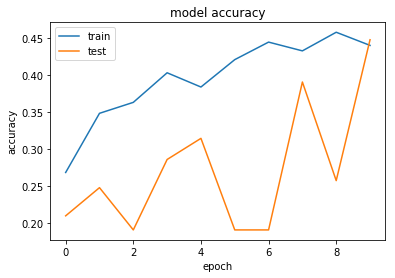

In [23]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 8 : Transfer Learning + mobilenet + dropout + GRU Layer

In [24]:
from keras.applications import  mobilenet

In [27]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [28]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
__________

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 78s 2s/step - loss: 1.3668 - categorical_accuracy: 0.4281 - val_loss: 1.2739 - val_categorical_accuracy: 0.6667

Epoch 00001: saving model to model_init_2020-11-0912_44_25.363423/model-00001-1.36677-0.42815-1.27389-0.66667.h5
Epoch 2/10
45/45 [==============================] - 62s 1s/step - loss: 0.7609 - categorical_accuracy: 0.7378 - val_loss: 1.3754 - val_categorical_accuracy: 0.7524

Epoch 00002: saving model to model_init_2020-11-0912_44_25.363423/model-00002-0.76087-0.73778-1.37537-0.75238.h5
Epoch 3/10
45/45 [==============================] - 70s 2s/step - loss: 0.5036 - categorical_accuracy: 0.8400 - val_loss: 1.5797 - val_categorical_accuracy: 0.6476

Epoch 00003: saving model to model_init_2020-11-0912_44_25.363423/model-00003-0.50361-0.84000-1.57967-0.64762.h5
Epoch 4/10
45/45 [==============================] - 67s 1s/step - loss: 0.3923 - categorical_accuracy: 0.8993 - val_loss: 1.8150 - val_categorical_accuracy: 0.6952

Epoch 00004:

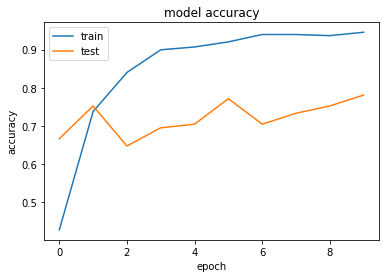

In [33]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 9 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased epoch

In [34]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [35]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
__________

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
num_epochs =15

In [40]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../val ; batch size = 15
Source path =  ../train ; batch size = 15
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 76s 2s/step - loss: 1.3758 - categorical_accuracy: 0.4341 - val_loss: 1.5995 - val_categorical_accuracy: 0.5333

Epoch 00001: saving model to model_init_2020-11-0912_44_25.363423/model-00001-1.37577-0.43407-1.59950-0.53333.h5
Epoch 2/15
45/45 [==============================] - 57s 1s/step - loss: 0.7638 - categorical_accuracy: 0.7481 - val_loss: 1.4597 - val_categorical_accuracy: 0.6571

Epoch 00002: saving model to model_init_2020-11-0912_44_25.363423/model-00002-0.76379-0.74815-1.45969-0.65714.h5
Epoch 3/15
45/45 [==============================] - 65s 1s/step - loss: 0.5664 - categorical_accuracy: 0.8178 - val_loss: 1.7611 - val_categorical_accuracy: 0.5905

Epoch 00003: saving model to model_init_2020-11-0912_44_25.363423/model-00003-0.56637-0.81778-1.76113-0.59048.h5
Epoch 4/15
45/45 [==============================] - 65s 1s/step - loss: 0.3838 - categorical_accuracy: 0.8830 - val_loss: 1.3377 - val_categorical_accuracy: 0.7619

Epoch 00004:

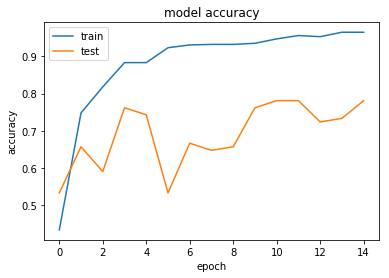

In [41]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 10 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased epoch + Increased Batch Size

In [42]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# increasing batch Size
batch_size = 20

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [43]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
__________

In [44]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [45]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [46]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [47]:
num_epochs =15

In [48]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ../train ; batch size = 20
Epoch 1/15
 ../val ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


32/34 [===========================>..] - ETA: 4s - loss: 1.4323 - categorical_accuracy: 0.3969

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 81s 2s/step - loss: 1.4086 - categorical_accuracy: 0.4103 - val_loss: 0.8658 - val_categorical_accuracy: 0.7500

Epoch 00001: saving model to model_init_2020-11-0912_44_25.363423/model-00001-1.40859-0.41029-0.86575-0.75000.h5
Epoch 2/15
34/34 [==============================] - 55s 2s/step - loss: 0.7364 - categorical_accuracy: 0.7206 - val_loss: 0.4949 - val_categorical_accuracy: 0.8100

Epoch 00002: saving model to model_init_2020-11-0912_44_25.363423/model-00002-0.73637-0.72059-0.49487-0.81000.h5
Epoch 3/15
34/34 [==============================] - 68s 2s/step - loss: 0.4034 - categorical_accuracy: 0.8618 - val_loss: 0.3859 - val_categorical_accuracy: 0.8200

Epoch 00003: saving model to model_init_2020-11-0912_44_25.363423/model-00003-0.40344-0.86176-0.38590-0.82000.h5
Epoch 4/15
34/34 [==============================] - 68s 2s/step - loss: 0.2918 - categorical_accuracy: 0.9250 - val_loss: 0.5609 - val_categorical_accuracy: 0.7900

Epoch 00004:

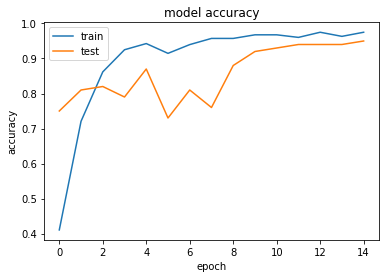

In [49]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 11 : Transfer Learning + mobilenet + dropout + GRU Layer + Increased Batch Size(More)

In [57]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# increasing batch Size
batch_size = 25

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobile_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(num_denselayers[1],activation='relu'))
model.add(Dropout(dropout))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [58]:
optimiser = "Adam" #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
__________

In [59]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [60]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [61]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [62]:
num_epochs =10

In [64]:
trained_model= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


24/27 [=========================>....] - ETA: 8s - loss: 0.1141 - categorical_accuracy: 0.9717 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


27/27 [==============================] - 74s 3s/step - loss: 0.2453 - categorical_accuracy: 0.9585 - val_loss: 0.4750 - val_categorical_accuracy: 0.8200

Epoch 00001: saving model to model_init_2020-11-0912_44_25.363423/model-00001-0.24535-0.95852-0.47499-0.82000.h5
Epoch 2/10
27/27 [==============================] - 69s 3s/step - loss: 0.3335 - categorical_accuracy: 0.9511 - val_loss: 0.4604 - val_categorical_accuracy: 0.8600

Epoch 00002: saving model to model_init_2020-11-0912_44_25.363423/model-00002-0.33354-0.95111-0.46040-0.86000.h5
Epoch 3/10
27/27 [==============================] - 69s 3s/step - loss: 0.3279 - categorical_accuracy: 0.9319 - val_loss: 0.2505 - val_categorical_accuracy: 0.9200

Epoch 00003: saving model to model_init_2020-11-0912_44_25.363423/model-00003-0.32792-0.93185-0.25051-0.92000.h5
Epoch 4/10
27/27 [==============================] - 69s 3s/step - loss: 0.3118 - categorical_accuracy: 0.9407 - val_loss: 0.4972 - val_categorical_accuracy: 0.8700

Epoch 00004:

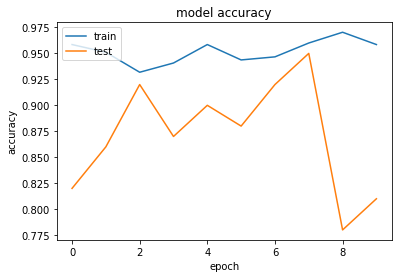

In [66]:
# summarize for model  accuracy
plt.plot(trained_model.history['categorical_accuracy'])
plt.plot(trained_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()